# Preparations

## Utils

In [ ]:
import numpy as np
import torch

def pretty_extract(zip_path, extract_to):
    import zipfile
    from tqdm.notebook import tqdm

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        png_files = [f for f in zip_ref.namelist() if f.endswith('.png')]

        for file in tqdm(png_files, desc="Extracting PNGs"):
            zip_ref.extract(file, path=extract_to)

def fast_hist(a, b, n):
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)


# Define the Cityscapes colormap (labelId → RGB)
CITYSCAPES_COLORS = np.array([
    [128, 64,128], [244, 35,232], [ 70, 70, 70], [102,102,156], [190,153,153],
    [153,153,153], [250,170, 30], [220,220,  0], [107,142, 35], [152,251,152],
    [ 70,130,180], [220, 20, 60], [255,  0,  0], [  0,  0,142], [  0,  0, 70],
    [  0, 60,100], [  0, 80,100], [  0,  0,230], [119, 11, 32], [  0,  0,  0]
], dtype=np.uint8)


# Mapping labelId image to RGB image
# Suppose 0 <= labelId < 20 or the 255 class
def decode_segmap(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label_id in np.unique(mask):
        if label_id == 255:
            color_mask[mask == label_id, :] = CITYSCAPES_COLORS[-1]
        elif label_id < 19:
            color_mask[mask == label_id, :] = CITYSCAPES_COLORS[label_id]
    return color_mask

def tensorToImageCompatible(tensor):
    """
    convert from a tensor of shape [C, H, W] where a normalization has been applied
    to an unnormalized tensor of shape [H, W, C],
    so *plt.imshow(tensorToImageCompatible(tensor))* works as expected.\n
    Intended to be used to recover the original element
    when CityScapes dataset apply the transformation
    - transform = TF.Compose([
        TF.ToTensor(),
        TF.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])])
    """
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return (tensor * std[:, None, None] + mean[:, None, None]).permute(1,2,0).numpy()

## CityScapes download

In [ ]:
# !pip install -q gdown

# file_id = "1MI8QsvjW0R6WDJiL49L7sDGpPWYAQB6O"
# !gdown https://drive.google.com/uc?id={file_id}

# pretty_extract("Cityscapes.zip", ".")


Downloading...
From (original): https://drive.google.com/uc?id=1MI8QsvjW0R6WDJiL49L7sDGpPWYAQB6O
From (redirected): https://drive.google.com/uc?id=1MI8QsvjW0R6WDJiL49L7sDGpPWYAQB6O&confirm=t&uuid=0c1e7e60-e5cb-4005-b226-a8748871c66c
To: /content/Cityscapes.zip
100% 4.97G/4.97G [01:16<00:00, 65.2MB/s]


Extracting PNGs:   0%|          | 0/6216 [00:00<?, ?it/s]

## GTA5 download

In [ ]:
# !pip install -q gdown

# file_id = "1PWavqXDxuifsyYvs2PFua9sdMl0JG8AE"
# !gdown https://drive.google.com/uc?id={file_id}

# !unzip Gta5_extended.zip -d /content/Gta5_extended

# TODO: need to test it
# pretty_extract("Gta5_extended.zip", "./Gta5_extended")

## Device

In [ ]:
import torch
# device = torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Metrics understanding

per_class_iou:
[0.32564599 0.3247863  0.34982271 0.29958257 0.26946873 0.27784281
 0.30452281 0.33199997 0.29712883 0.34828325 0.30336623 0.31920901
 0.32651629 0.29198541 0.26781922 0.33385824 0.32134665 0.30436818
 0.25904916 0.31440866]
mIoU:0.30855055058672987


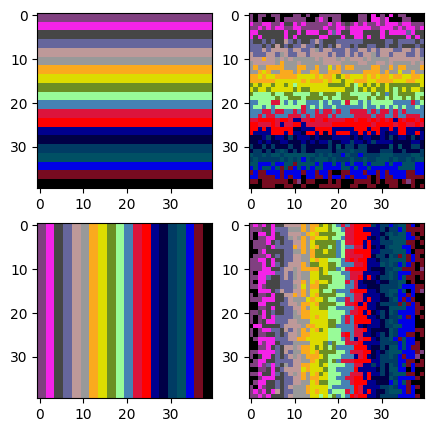

In [ ]:
import torch
import numpy as np

B = 2
H = 40
W = 40
n_classes = 20

target = torch.randint(0, n_classes, (B, H, W), dtype=torch.int64)

step = H//n_classes
for i in range(n_classes):
    target[0, i*step:(i+1)*step, :] = i

step = W//n_classes
for i in range(n_classes):
    target[1, :, i*step:(i+1)*step] = i

noise = torch.randint(-10, 11, (B, H, W), dtype=torch.int64)//10
pred = (target + noise)% n_classes

iou_class = np.zeros(n_classes)
for i in range(B):
    iou_class += per_class_iou(fast_hist(target[i].numpy(), pred[i].numpy(), n_classes))

# print(f"target=\n{target}")
# print(f"pred=\n{pred}")
# print(f"hist=\n{hist}")
print(f"per_class_iou:\n{iou_class/B}")
print(f"mIoU:{iou_class[iou_class > 0].mean()/B}")

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(5,5))
axs[0, 0].imshow(decode_segmap(target[0]))
axs[0, 1].imshow(decode_segmap(pred[0]))

axs[1,0].imshow(decode_segmap(target[1]))
axs[1,1].imshow(decode_segmap(pred[1]))

None

## Cityscapes implementation

In [ ]:
from torch.utils.data import Dataset

import os
from torchvision.transforms import ToTensor, ToPILImage
import cv2
from PIL import Image

from torchvision.io import decode_image, read_image
from torchvision.io.image import ImageReadMode

import numpy as np
import matplotlib.pyplot as plt

class CityScapes(Dataset):
    def __init__(self, rootdir, split="train", targetdir="gtFine", imgdir="images", transform=None, target_transform=None):
        super(CityScapes, self).__init__()

        self.rootdir = rootdir
        self.split = split
        self.targetdir = os.path.join(self.rootdir, targetdir, self.split) # ./gtFine/train/
        self.imgdir = os.path.join(self.rootdir, imgdir, self.split) # ./images/train/
        self.transform = transform
        self.target_transform = target_transform

        self.imgs_path = []
        self.targets_color_path = []
        self.targets_labelIds_path = []

        for city in os.listdir(self.imgdir): # frankfurt
            img_city_dir = os.path.join(self.imgdir, city) # ./images/train/frankfurt/
            target_city_dir = os.path.join(self.targetdir, city) # ./gtFine/train/frankfurt/

            for img_path in os.listdir(img_city_dir): # frankfurt_000000_000294_leftImg8bit.png
                if img_path.endswith(".png"):
                  self.imgs_path.append(os.path.join(img_city_dir, img_path)) # ./images/train/frankfurt/frankfurt_000000_000294_leftImg8bit.png

                  target_color_path = img_path.replace("leftImg8bit", "gtFine_color") # frankfurt_000000_000294_gtFine_color.png
                  target_labelIds_path = img_path.replace("leftImg8bit", "gtFine_labelTrainIds") # frankfurt_000000_000294_gtFine_labelTrainIds.png

                  self.targets_color_path.append(os.path.join(target_city_dir, target_color_path)) # ./gtFine/train/frankfurt/frankfurt_000000_000294_gtFine_color.png
                  self.targets_labelIds_path.append(os.path.join(target_city_dir, target_labelIds_path)) # ./gtFine/train/frankfurt/frankfurt_000000_000294_gtFine_labelTrainIds.png

    def __getitem__(self, idx):
        image = Image.open(self.imgs_path[idx]).convert('RGB')
        # image = decode_image(self.imgs_path[idx]).to(dtype=torch.float32)

        target_color = Image.open(self.targets_color_path[idx]).convert('RGB')

        target_labelIds = cv2.imread(self.targets_labelIds_path[idx], cv2.IMREAD_UNCHANGED).astype(np.long)
        # target_labelIds = Image.open(self.targets_labelIds_path[idx])
        # target_labelIds =  read_image(self.targets_labelIds_path[idx], mode=ImageReadMode.GRAY)
        # target_labelIds = decode_image(self.targets_labelIds_path[idx]).to(dtype=torch.uint8)

        if self.transform is not None:
            image = self.transform(image)
            target_color = self.transform(target_color)
        if self.target_transform is not None:
            target_labelIds = self.target_transform(target_labelIds)

        return image, target_color, target_labelIds
        # return image, target_labelIds

    def __len__(self):
        return len(self.imgs_path)


## GTA5 implementation

### Label to color

In [ ]:
from abc import ABCMeta
from dataclasses import dataclass
from typing import Tuple

class BaseGTALabels(metaclass=ABCMeta):
    pass

@dataclass
class GTA5Label:
    ID: int
    color: Tuple[int, int, int]

class GTA5Labels_TaskCV2017(BaseGTALabels):
    road = GTA5Label(ID=0, color=(128, 64, 128))
    sidewalk = GTA5Label(ID=1, color=(244, 35, 232))
    building = GTA5Label(ID=2, color=(70, 70, 70))
    wall = GTA5Label(ID=3, color=(102, 102, 156))
    fence = GTA5Label(ID=4, color=(190, 153, 153))
    pole = GTA5Label(ID=5, color=(153, 153, 153))
    light = GTA5Label(ID=6, color=(250, 170, 30))
    sign = GTA5Label(ID=7, color=(220, 220, 0))
    vegetation = GTA5Label(ID=8, color=(107, 142, 35))
    terrain = GTA5Label(ID=9, color=(152, 251, 152))
    sky = GTA5Label(ID=10, color=(70, 130, 180))
    person = GTA5Label(ID=11, color=(220, 20, 60))
    rider = GTA5Label(ID=12, color=(255, 0, 0))
    car = GTA5Label(ID=13, color=(0, 0, 142))
    truck = GTA5Label(ID=14, color=(0, 0, 70))
    bus = GTA5Label(ID=15, color=(0, 60, 100))
    train = GTA5Label(ID=16, color=(0, 80, 100))
    motocycle = GTA5Label(ID=17, color=(0, 0, 230))
    bicycle = GTA5Label(ID=18, color=(119, 11, 32))
    void = GTA5Label(ID=255, color=(0,0,0))

    list_ = [
        road,
        sidewalk,
        building,
        wall,
        fence,
        pole,
        light,
        sign,
        vegetation,
        terrain,
        sky,
        person,
        rider,
        car,
        truck,
        bus,
        train,
        motocycle,
        bicycle,
        void
    ]

    @property
    def support_id_list(self):
        ret = [label.ID for label in self.list_]
        return ret

### Dataset

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm

class GTA5(Dataset):
    def __init__(self, rootdir, split, train_split_percent, split_seed = None, targetdir="labels", imgdir="images", transform=None, target_transform=None):
        super(GTA5, self).__init__()

        assert split in ["train", "val"]
        assert train_split_percent >= 0 and train_split_percent <= 1

        self.rootdir = rootdir
        self.split = split
        self.section = int(self.split=="val")

        self.train_split_percent = train_split_percent

        self.targetdir = os.path.join(self.rootdir, targetdir) # ./labels
        self.imgdir = os.path.join(self.rootdir, imgdir) # ./images
        self.transform = transform
        self.target_transform = target_transform

        all_names = os.listdir(self.imgdir)

        self.imgs_path = [[],[]]
        self.targets_color_path = [[],[]]
        self.targets_labelIds_path = [[],[]]

        self.split_seed = split_seed
        if self.split_seed is not None:
            np.random.seed(self.split_seed)

        self.train_val_mask = np.ones(len(all_names), dtype=bool)
        self.train_val_mask[:int(len(all_names)*(self.train_split_percent))] = False

        np.random.shuffle(self.train_val_mask)

        for i, image_file in enumerate(all_names): # 00001.png
            if image_file.endswith(".png"):
                section = int(self.train_val_mask[i])
                self.imgs_path[section].append(os.path.join(self.imgdir, image_file)) #./images/00001.png

                target_color_path = image_file # 00001.png
                target_labelsId_path = image_file.split(".")[0]+"_labelIds.png" # labelIds_00001.png

                self.targets_color_path[section].append(os.path.join(self.targetdir, target_color_path)) #./labels/00001.png
                self.targets_labelIds_path[section].append(os.path.join(self.targetdir, target_labelsId_path)) #./labels/labelIDs_00001.png

    def create_target_img(self):
        list_ = GTA5Labels_TaskCV2017().list_

        for s in range(2):
          for i, img_path in tqdm(enumerate(self.targets_color_path[s])):
              image_numpy = np.asarray(Image.open(img_path).convert('RGB'))

              H, W, _ = image_numpy.shape
              label_image = 255*np.ones((H, W), dtype=np.uint8)

              for label in list_:
                  label_image[(image_numpy == label.color).all(axis=-1)] = label.ID

              new_img = Image.fromarray(label_image)
              new_img.save(self.targets_labelIds_path[s][i])

    def __getitem__(self, idx):
        image = Image.open(self.imgs_path[self.section][idx]).convert('RGB')

        target_color = Image.open(self.targets_color_path[self.section][idx]).convert('RGB')
        target_labelIds = cv2.imread(self.targets_labelIds_path[self.section][idx], cv2.IMREAD_UNCHANGED).astype(np.long)

        if self.transform is not None:
            image = self.transform(image)
            target_color = self.transform(target_color)
        if self.target_transform is not None:
            target_labelIds = self.target_transform(target_labelIds)

        return image, target_color, target_labelIds

    def __len__(self):
        return len(self.imgs_path[self.section])


## Bisenet

In [ ]:
import torch
from torch import nn
import warnings
warnings.filterwarnings(action='ignore')

import torch
from torchvision import models

class resnet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


class resnet101(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet101(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


def build_contextpath(name):
    model = {
        'resnet18': resnet18(pretrained=True),
        'resnet101': resnet101(pretrained=True)
    }
    return model[name]

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))


class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x


class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.sigmoid(self.bn(x))
        # x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet101 3328 = 256(from spatial path) + 1024(from context path) + 2048(from context path)
        # resnet18  1024 = 256(from spatial path) + 256(from context path) + 512(from context path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x


class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        # build context path
        self.context_path = build_contextpath(name=context_path)

        # build attention refinement module  for resnet 101
        if context_path == 'resnet101':
            self.attention_refinement_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_refinement_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'resnet18':
            # build attention refinement module  for resnet 18
            self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
            self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

        self.init_weight()

        self.mul_lr = []
        self.mul_lr.append(self.saptial_path)
        self.mul_lr.append(self.attention_refinement_module1)
        self.mul_lr.append(self.attention_refinement_module2)
        self.mul_lr.append(self.supervision1)
        self.mul_lr.append(self.supervision2)
        self.mul_lr.append(self.feature_fusion_module)
        self.mul_lr.append(self.conv)

    def init_weight(self):
        for name, m in self.named_modules():
            if 'context_path' not in name:
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    m.eps = 1e-5
                    m.momentum = 0.1
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)

        if self.training == True:
            return result, cx1_sup, cx2_sup

        return result


## Wandb

In [ ]:
!pip -q install wandb

In [52]:
def test_the_run():
    import wandb

    from torch.utils.data import DataLoader
    import torchvision.transforms as TF

    import numpy as np

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set the context of the run
    B = 4
    H = 32
    W = 64
    n_classes = 19

    context_path = "resnet101"
    epochs = 10
    lr=0.0001
    momentum=0.9
    weight_decay=5e-4
    dataset = "Cityscapes"

    transform = TF.Compose([
        TF.ToTensor(),
        TF.Resize((H,W)),
        TF.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    target_transform = TF.Compose([
        TF.ToTensor(),
        TF.Resize((H, W), interpolation=TF.InterpolationMode.NEAREST),
    ])

    # Choose the dataset
    if dataset == "Cityscapes":
        data = CityScapes("/content/Cityscapes/Cityspaces", split="train", transform=transform, target_transform=target_transform)
    elif dataset == "GTA5":
        data = GTA5("/content/Gta5_extended", split="train", train_split_percent=0.6, transform=transform, target_transform=target_transform)
    else:
        raise Exception("Wrong dataset name")

    dataloader = DataLoader(data, batch_size=B, shuffle=True)

    model = BiSeNet(n_classes, context_path).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # Start a new wandb run to track this script.
    run = wandb.init(
        # Set the wandb entity where your project will be logged (generally your team name).
        entity="Machine_learning_and_Deep_learning_labs",
        # Set the wandb project where this run will be logged.
        project="Semantic Segmentation",
        name=f"BiSeNet-{context_path}",
        tags=[f"step2"],
        # Track hyperparameters and run metadata.
        config={
            "learning_rate": lr,
            "momentum": momentum,
            "weight_decay": weight_decay,
            "architecture": f"BiSeNet-{context_path}",
            "dataset": dataset,
            "epochs": epochs,
            "batch": B
        },
    )

    # Body of the run (here simulation of validation step)
    model.eval()

    running_hist = np.zeros((n_classes,n_classes))
    for i in range(epochs):
        running_loss = 0.0

        # We are considering only one batch of the epoch just for visualization purpose
        inputs, _, targets = next(iter(dataloader))
        inputs = inputs.to(device)
        targets = targets.squeeze().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        predicted = outputs.argmax(1)

        hist_batch = np.zeros((n_classes, n_classes))
        for i in range(len(inputs)):
            hist_batch += fast_hist(targets[i].cpu().numpy(), predicted[i].cpu().numpy(), n_classes)

        running_loss = loss.item()
        running_hist += hist_batch
        mIou = per_class_iou(hist_batch)

        run.log({"loss": running_loss, "mIou": 100*mIou[mIou > 0].mean()})


    # After your loop ends:
    plt.figure(figsize=(10, 8))
    sns.heatmap(np.round(running_hist/running_hist.sum(axis=1)[:,np.newaxis], 2), annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    # Log the matplotlib figure as an image
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.close()


    # How to save the model weights to wandb

    # weights_path = f"{run.dir}/weights.pth"
    # torch.save(model.state_dict(), weights_path)

    # # TODO: add artifact version
    # artifact = wandb.Artifact(name=f"BiseNet-{context_path}", type="model")
    # artifact.add_file(weights_path)

    # run.log_artifact(artifact)

    # End the run
    run.finish()

test_the_run()

loss,▃█▄▇▂▅▁▃▁▄
mIou,▄ ▁▁▃▅▃▁▃█
loss,11.82229
mIou,19.38611


# Train/Val loops

### Train Loop

In [73]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import wandb

# TODO: maybe last class (void) converted to n_classes-1 due to argmax
def train(epoch:int, model:nn.Module, train_loader:DataLoader, criterion:nn.Module, optimizer:optim.Optimizer) -> tuple[float, float, np.ndarray]:
    global device
    global n_classes

    model.train()
    train_loss = 0.0
    train_hist = np.zeros((n_classes,n_classes))

    for batch_idx, (inputs, _, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.squeeze().to(device)

        outputs, cx1_sup, cx2_sup = model(inputs)

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = outputs.argmax(1)

        hist_batch = np.zeros((n_classes, n_classes))
        for i in range(len(inputs)):
            hist_batch += fast_hist(targets[i].cpu().numpy(), predicted[i].cpu().numpy(), n_classes)

        train_loss += loss.item()
        train_hist += hist_batch
        iou_batch = per_class_iou(hist_batch)

        if batch_idx % 50 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx*len(inputs) / len(train_loader.dataset):.0f}%)]\tLoss: {loss.item():.6f}')
            print(f"mIoU:{iou_batch[iou_batch > 0].mean():.4f}")


        wandb.log({"batch_train_loss": loss.item(), "batch_train_mIou": 100*iou_batch[iou_batch > 0].mean()})

    train_loss = train_loss / len(train_loader)

    train_iou_class = per_class_iou(train_hist)
    train_mIou = train_iou_class[train_iou_class > 0].mean()

    print(f'Train Epoch: {epoch} Loss: {train_loss:.6f} mIoU: {train_mIou:.4f}%')
    return train_loss, train_mIou, train_hist


### Validation loop

In [69]:
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np

# TODO: add wandb.log as in train loop
def validate(epoch:int, model:nn.Module, val_loader:DataLoader, criterion:nn.Module) -> tuple[float, float, np.ndarray]:
    global device
    global n_classes

    model.eval()
    val_loss = 0.0
    val_hist = np.zeros((n_classes,n_classes))

    with torch.no_grad():
        for batch_idx, (inputs, _, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.squeeze().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            predicted = outputs.argmax(1)

            hist_batch = np.zeros((n_classes, n_classes))
            for i in range(len(inputs)):
                hist_batch += fast_hist(targets[i].cpu().numpy(), predicted[i].cpu().numpy(), n_classes)

            val_loss += loss.item()
            val_hist += hist_batch

            if batch_idx % 100 == 0:
                print(f'Val Epoch: {epoch} [{batch_idx * len(inputs)}/{len(val_loader.dataset)} ({100. * batch_idx*len(inputs) / len(val_loader.dataset):.0f}%)]\tLoss: {loss.item():.6f}')
                iou_batch = per_class_iou(hist_batch)
                print(f"mIoU:{iou_batch[iou_batch > 0].mean():.4f}")

    val_loss = val_loss / len(val_loader)

    val_iou_class = per_class_iou(val_hist)
    val_mIou = 100. * val_iou_class[val_iou_class > 0].mean()

    print(f'Validation Loss: {val_loss:.6f} mIou: {val_mIou:.2f}%')
    return val_loss, val_mIou, val_hist

### Testing of loops

In [74]:
from torch.utils.data import DataLoader
import torchvision.transforms as TF
import torch.nn as nn
import torch.optim as optim

B = 10
H = 32
W = 64
n_classes = 19

context_path = "resnet101"
epochs = 4
lr=0.0001
momentum=0.9
weight_decay=5e-4
dataset = "Cityscapes"

transform = TF.Compose([
    TF.ToTensor(),
    TF.Resize((H,W)),
    TF.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])
target_transform = TF.Compose([
    TF.ToTensor(),
    TF.Resize((H, W), interpolation=TF.InterpolationMode.NEAREST),
])

if dataset == "Cityscapes":
    data = CityScapes("/content/Cityscapes/Cityspaces", split="train", transform=transform, target_transform=target_transform)
else:
    data = GTA5("/content/Gta5_extended", split="train", train_split_percent=0.6, transform=transform, target_transform=target_transform)

dataloader = DataLoader(data, batch_size=B, shuffle=True)

model = BiSeNet(n_classes, context_path).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)


In [75]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="Machine_learning_and_Deep_learning_labs",
    # Set the wandb project where this run will be logged.
    project="Semantic Segmentation",
    name=f"BiSeNet-{context_path}",
    tags=[f"step2"],
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": lr,
        "momentum": momentum,
        "weight_decay": weight_decay,
        "architecture": f"BiSeNet-{context_path}",
        "dataset": dataset,
        "epochs": epochs,
        "batch": B
    },
)

for i in range(epochs):
    train_loss, train_mIou, train_hist = train(i+1, model, dataloader, criterion, optimizer)

    run.log({"train_loss": train_loss, "train_mIou": 100*train_mIou})

    plt.figure(figsize=(10, 8))
    sns.heatmap(np.round(train_hist/train_hist.sum(axis=1)[:,np.newaxis], 2), annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    # Log the matplotlib figure as an image
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.close()

    # img_tensor, color_tensor, label = next(iter(dataloader))

    # out = model(img_tensor.to(device))[0][0].argmax(0).cpu()

    # img = tensorToImageCompatible(img_tensor[i])
    # color = tensorToImageCompatible(color_tensor[i])
    # decoded_from_labelId = decode_segmap(label[i, 0])
    # out_decoded = decode_segmap(out)

    # fig, ax = plt.subplots(2,2, figsize=(10,10), layout="tight")

    # ax[0,0].set_title("Original image")
    # ax[0,0].imshow(img)
    # ax[0,0].axis('off')

    # ax[0,1].set_title("Colored by label")
    # ax[0,1].imshow(color)
    # ax[0,1].axis('off')

    # ax[1,0].set_title("Reconstructed from class ID")
    # ax[1,0].imshow(decoded_from_labelId)
    # ax[1,0].axis('off')

    # ax[1,1].set_title("Raw Classes")
    # ax[1,1].imshow(out_decoded)
    # ax[1,1].axis('off')

    # fig.show()

run.finish()

Train Epoch: 1 [0/1572 (0%)]	Loss: 3.551325
mIoU:0.0465
Train Epoch: 1 [1000/1572 (64%)]	Loss: 2.027426
mIoU:0.1163
Train Epoch: 1 Loss: 2.084654 mIoU: 7.3973%
Train Epoch: 2 [0/1572 (0%)]	Loss: 1.621870
mIoU:0.2579
Train Epoch: 2 [1000/1572 (64%)]	Loss: 1.634115
mIoU:0.3144
Train Epoch: 2 Loss: 1.636432 mIoU: 9.7322%
Train Epoch: 3 [0/1572 (0%)]	Loss: 1.444031
mIoU:0.2397
Train Epoch: 3 [1000/1572 (64%)]	Loss: 1.650126
mIoU:0.2346
Train Epoch: 3 Loss: 1.498599 mIoU: 11.8199%
Train Epoch: 4 [0/1572 (0%)]	Loss: 1.496015
mIoU:0.3417
Train Epoch: 4 [1000/1572 (64%)]	Loss: 1.473212
mIoU:0.2488
Train Epoch: 4 Loss: 1.403110 mIoU: 15.6329%


batch_train_loss,▃▃▃▄▄▅▅▆▆▇█▁▁▃▄▄▄▆▂▂▃▃▃▄▄▅▅▅▆▁▁▂▂▂▃▃▄▄▄▅
batch_train_mIou,▁▂▂▃▁▃▄▃▄▅▃▄▄▅▄█▅▆▆▄▆▅▇▅▇▅▆▅▆▅▇▆▅▅▇▆█▇▇▆
train_loss,█▃▂▁
train_mIou,▁▃▅█
batch_train_loss,221.69143
batch_train_mIou,0.30822
train_loss,1.40311
train_mIou,15.63285


Text(0.5, 1.0, 'Normalized Confusion Matrix')

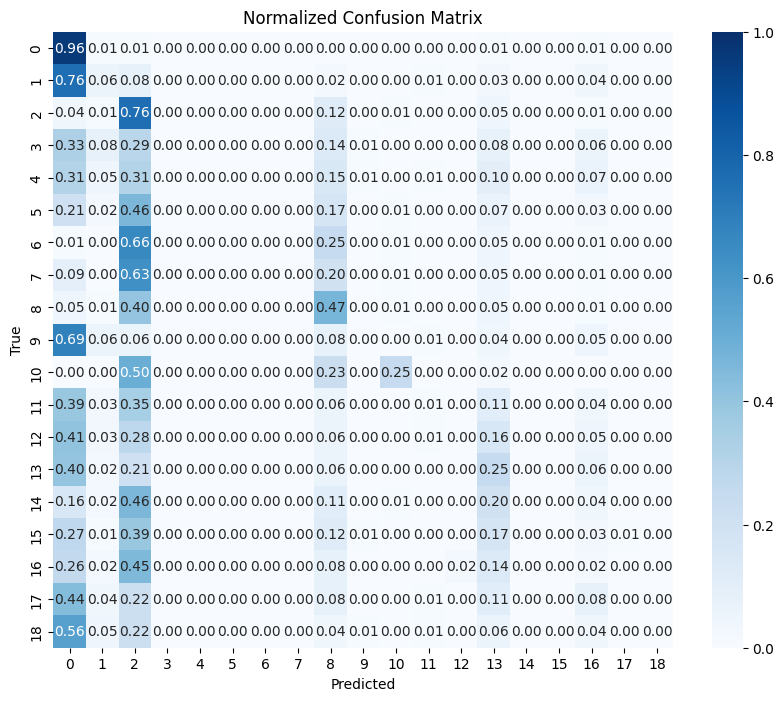

In [97]:
plt.figure(figsize=(10, 8))
sns.heatmap(np.round(train_hist/train_hist.sum(axis=1)[:,np.newaxis], 2), annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Machine learning

## Dataset utilization

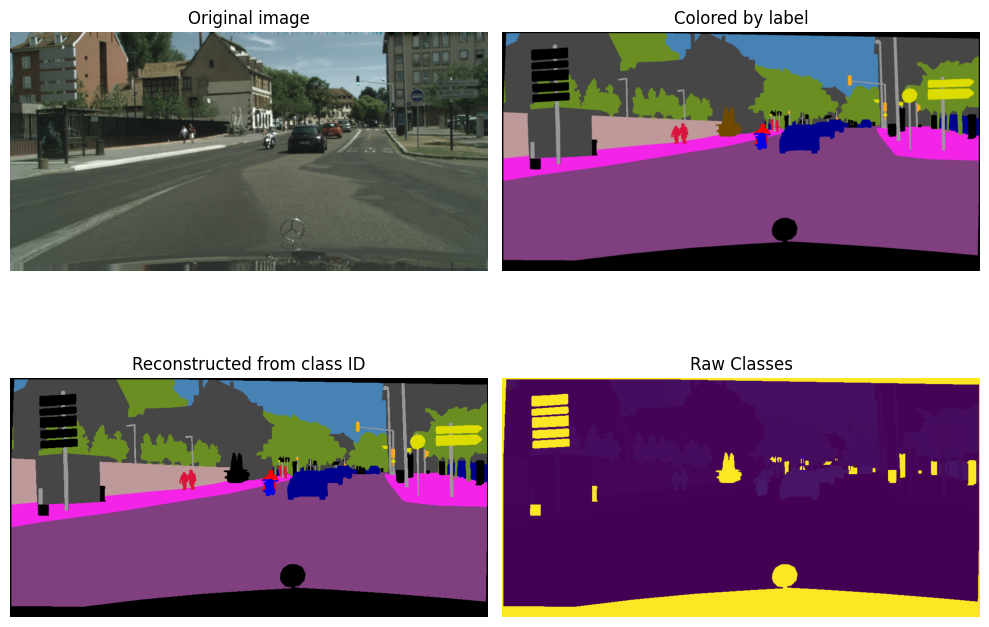

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as TF

import matplotlib.pyplot as plt

B = 3
H = 512
W = 1024
dataset = "Cityscapes"

transform = TF.Compose([
    TF.ToTensor(),
    TF.Resize((H,W)),
    TF.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])
target_transform = TF.Compose([
    TF.ToTensor(),
    TF.Resize((H, W), interpolation=TF.InterpolationMode.NEAREST),
])

if dataset == "Cityscapes":
    data = CityScapes("/content/Cityscapes/Cityspaces", split="train", transform=transform, target_transform=target_transform)
elif dataset == "GTA5":
    data = GTA5("/content/Gta5_extended", split="train", train_split_percent=0.6, transform=transform, target_transform=target_transform)
else:
    raise Exception("Wrong dataset name")

dataloader = DataLoader(data, batch_size=B, shuffle=True)
i = 0
img_tensor, color_tensor, label = next(iter(dataloader))

img = tensorToImageCompatible(img_tensor[i])
color = tensorToImageCompatible(color_tensor[i])
decoded_from_labelId = decode_segmap(label[i, 0])

fig, ax = plt.subplots(2,2, figsize=(10,10), layout="tight")

ax[0,0].set_title("Original image")
ax[0,0].imshow(img)
ax[0,0].axis('off')

ax[0,1].set_title("Colored by label")
ax[0,1].imshow(color)
ax[0,1].axis('off')

ax[1,0].set_title("Reconstructed from class ID")
ax[1,0].imshow(decoded_from_labelId)
ax[1,0].axis('off')

ax[1,1].set_title("Raw Classes")
ax[1,1].imshow(label[i, 0])
ax[1,1].axis('off')

None

## GTA utilization

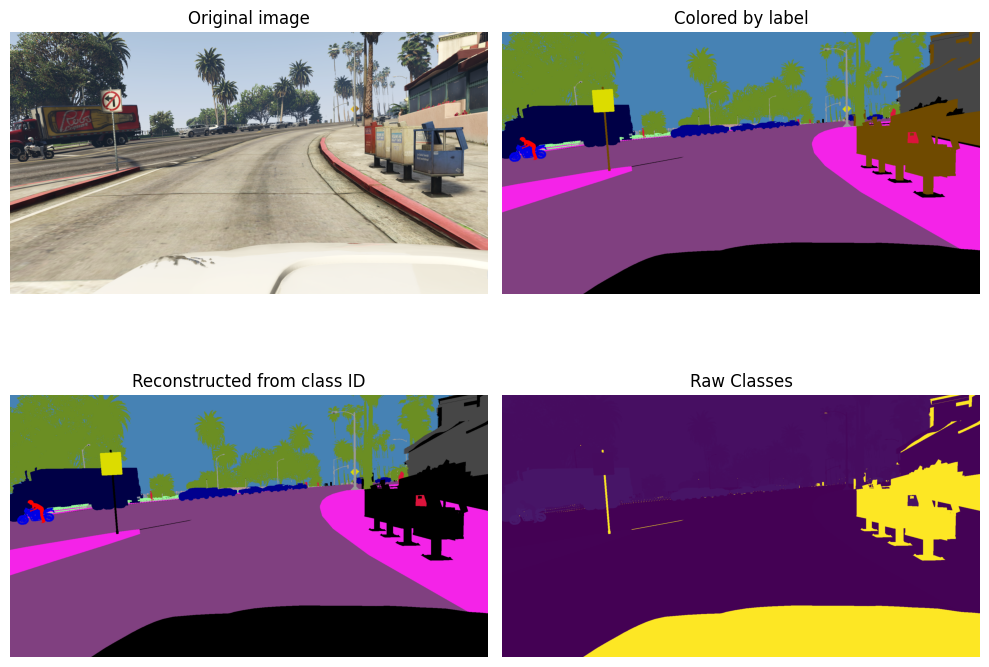

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as TF

import matplotlib.pyplot as plt

transform = TF.Compose([
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

data = GTA5(rootdir="/content/Gta5_extended", split="val", train_split_percent=0.6, transform=transform)
dataloader = DataLoader(data, batch_size=8, shuffle=False)

i = 0
img_tensor, color_tensor, label = next(iter(dataloader))

img = tensorToImageCompatible(img_tensor[i])
color = tensorToImageCompatible(color_tensor[i])
decoded_from_labelId = decode_segmap(label[i])

fig, ax = plt.subplots(2,2, figsize=(10,10), layout="tight")

ax[0,0].set_title("Original image")
ax[0,0].imshow(img)
ax[0,0].axis('off')

ax[0,1].set_title("Colored by label")
ax[0,1].imshow(color)
ax[0,1].axis('off')

ax[1,0].set_title("Reconstructed from class ID")
ax[1,0].imshow(decoded_from_labelId)
ax[1,0].axis('off')

ax[1,1].set_title("Raw Classes")
ax[1,1].imshow(label[i])
ax[1,1].axis('off')

None